In [1]:
cd ../../

/workspaces/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.war_exp.cv import nested_cv_fit, cv_fit, bootstrap_fit

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'rerf'

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")
bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / "low-pass=1000Hz-downsample=500"
)

# subject identifiers
subject = "efri14"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [4]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


In [5]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname
epochs = mne.read_epochs(fpath, proj=False, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

# get shape of data
epochs_data = epochs.get_data()
ntrials, nchs, nsteps = epochs_data.shape
print(f'epochs_data.shape = {epochs_data.shape}')

Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/low-pass=1000Hz-downsample=500/efri14/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...     998.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
154 matching events found
No baseline correction applied
Dropped 26 epochs: 14, 16, 17, 20, 21, 27, 28, 29, 31, 33, 54, 63, 79, 84, 87, 91, 110, 118, 123, 125, 132, 135, 138, 140, 141, 148
epochs_data.shape = (128, 81, 750)


In [6]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = epochs_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

## Multi-label Stratified KFold

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


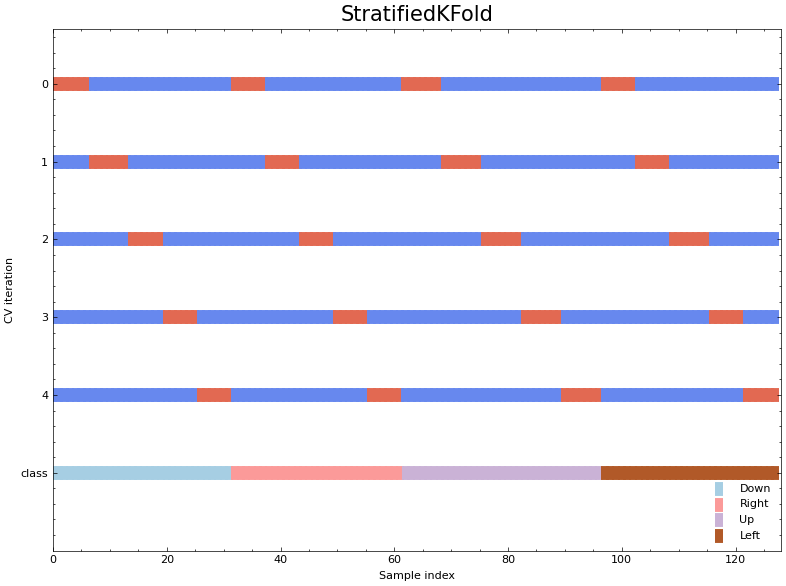

In [7]:
# Perform K-Fold cross validation
n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [42]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

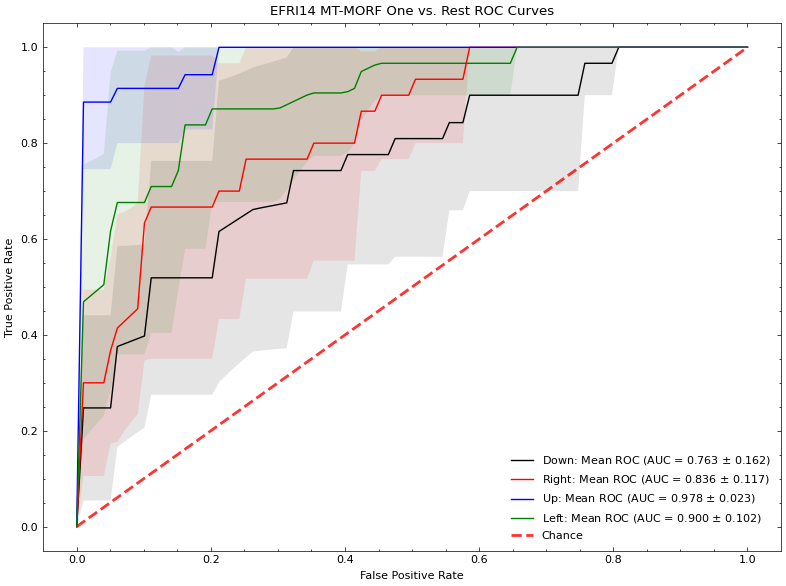

In [43]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout();

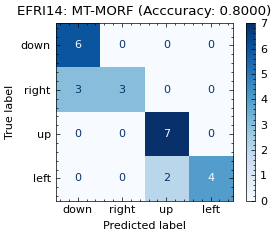

In [44]:
ind = np.argmax(stratified_kf_scores['test_accuracy'])
best_clf = stratified_kf_scores['estimator'][ind]

# fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
fig, ax = plt.subplots(dpi=100)
plot_confusion_matrix(best_clf, X[stratified_kf_scores['test_inds'][ind]], y[stratified_kf_scores['test_inds'][ind]], cmap='Blues', ax=ax)
ax.set(xticklabels=['down', 'right', 'up', 'left'], yticklabels=['down', 'right', 'up', 'left'], 
        title=f"{subject.upper()}: MT-MORF (Acccuracy: {max(stratified_kf_scores['test_accuracy']):.4f})")
fig.tight_layout();

In [11]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores_srerf = cv_fit(srerf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_srerf.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

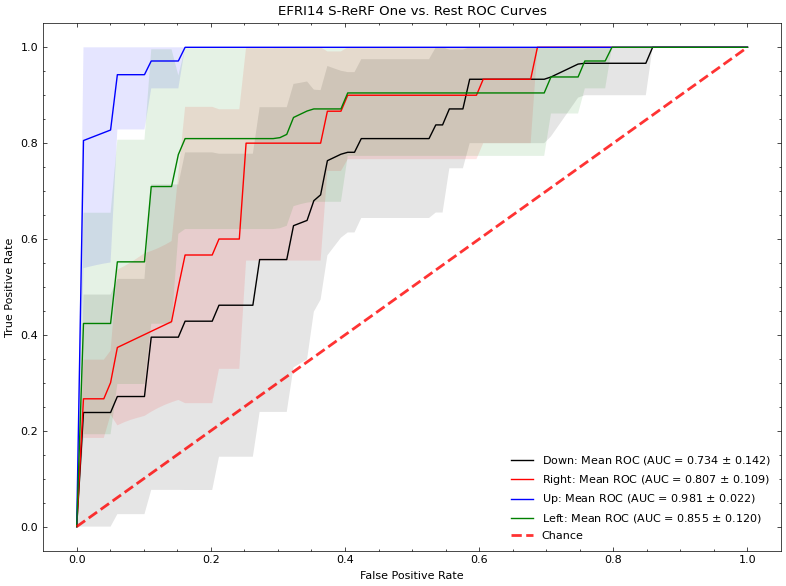

In [12]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_srerf["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_srerf["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} S-ReRF One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout()

In [13]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

clf = LogisticRegression(random_state=rng)

stratified_kf_scores_lr = cv_fit(clf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_lr.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

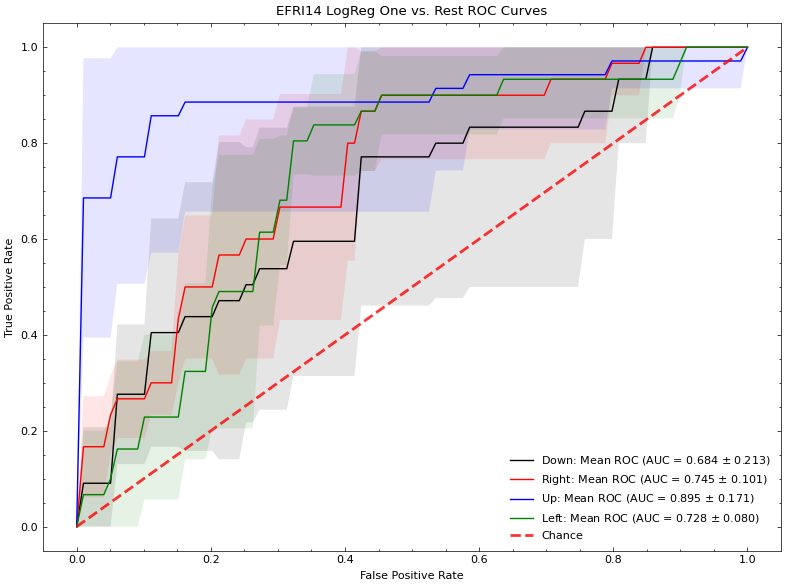

In [14]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_lr["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_lr["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} LogReg One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout()

In [15]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

rf = RandomForestClassifier(random_state=rng)

stratified_kf_scores_rf = cv_fit(rf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_rf.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

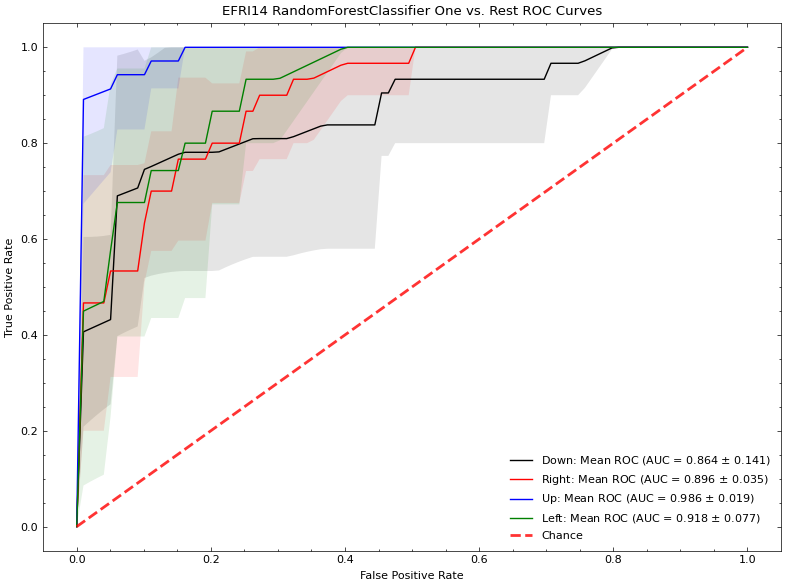

In [16]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_rf["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_rf["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} RandomForestClassifier One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout()

In [17]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

stratified_kf_scores_dummy = cv_fit(dummy, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_dummy.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

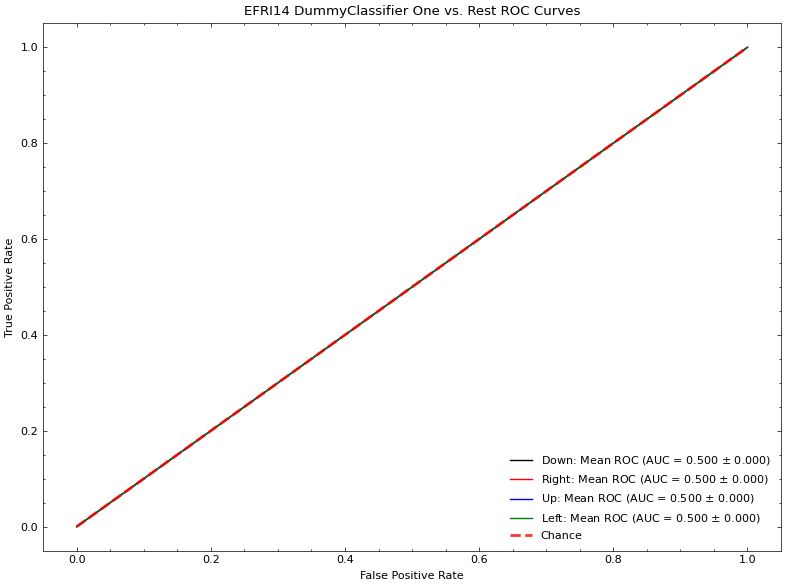

In [18]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_dummy["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_dummy["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} DummyClassifier One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout()

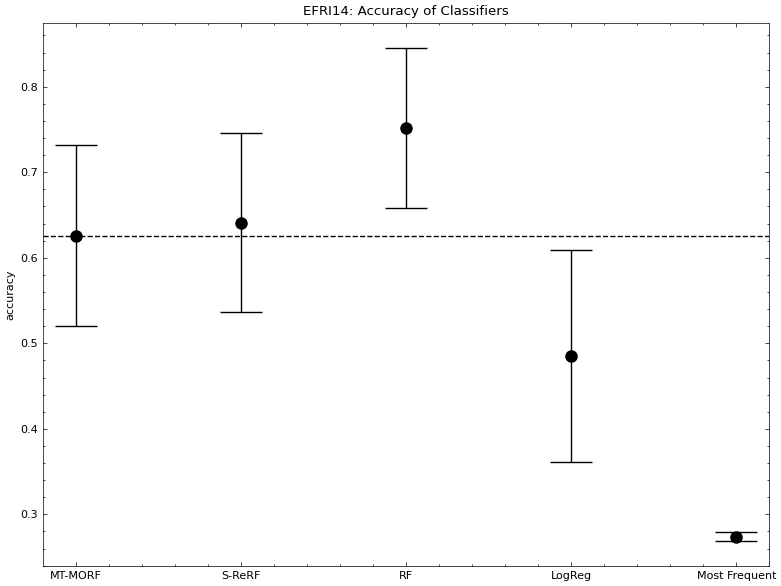

In [19]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

clf_names = [
    'MT-MORF', 
    'S-ReRF', 
    'RF', 
    'LogReg', 
    'Most Frequent'
]
accs = np.array([
        np.mean(stratified_kf_scores["test_accuracy"]), 
        np.mean(stratified_kf_scores_srerf["test_accuracy"]), 
        np.mean(stratified_kf_scores_rf["test_accuracy"]),
        np.mean(stratified_kf_scores_lr["test_accuracy"]),
        np.mean(stratified_kf_scores_dummy["test_accuracy"]),
    ])
acc_std = np.array([
        np.std(stratified_kf_scores["test_accuracy"]), 
        np.std(stratified_kf_scores_srerf["test_accuracy"]),
        np.std(stratified_kf_scores_rf["test_accuracy"]),
        np.std(stratified_kf_scores_lr["test_accuracy"]),
        np.std(stratified_kf_scores_dummy["test_accuracy"]),
    ])

ax.errorbar(clf_names, accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(stratified_kf_scores["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers")
fig.tight_layout();

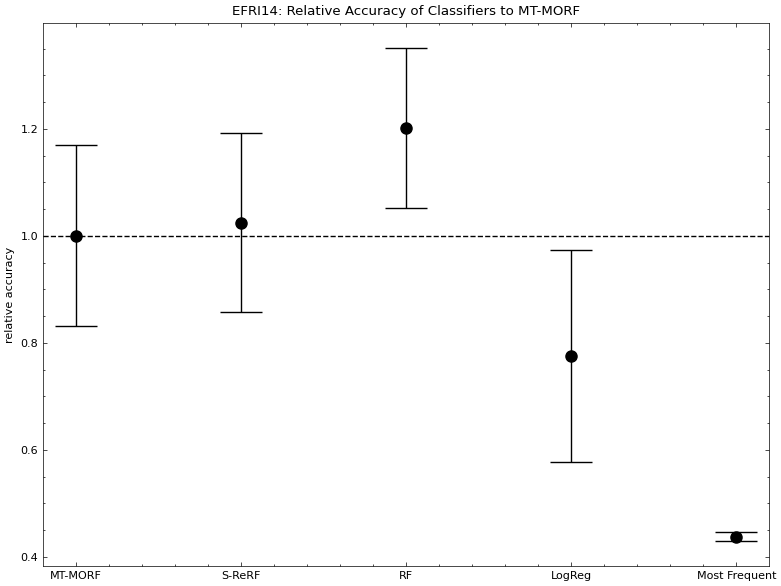

In [20]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

clf_names = [
    'MT-MORF', 
    'S-ReRF', 
    'RF', 
    'LogReg', 
    'Most Frequent'
]
accs = np.array([
        np.mean(stratified_kf_scores["test_accuracy"]), 
        np.mean(stratified_kf_scores_srerf["test_accuracy"]), 
        np.mean(stratified_kf_scores_rf["test_accuracy"]),
        np.mean(stratified_kf_scores_lr["test_accuracy"]),
        np.mean(stratified_kf_scores_dummy["test_accuracy"]),
    ])
acc_std = np.array([
        np.std(stratified_kf_scores["test_accuracy"]), 
        np.std(stratified_kf_scores_srerf["test_accuracy"]),
        np.std(stratified_kf_scores_rf["test_accuracy"]),
        np.std(stratified_kf_scores_lr["test_accuracy"]),
        np.std(stratified_kf_scores_dummy["test_accuracy"]),
    ])

rel_accs = accs / np.mean(stratified_kf_scores["test_accuracy"])
rel_acc_std = acc_std / np.mean(stratified_kf_scores["test_accuracy"])

ax.errorbar(clf_names, rel_accs, yerr=rel_acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(1, lw=1, color='k', ls='--')
ax.set(ylabel="relative accuracy", title=f"{subject.upper()}: Relative Accuracy of Classifiers to MT-MORF")
fig.tight_layout();

## Feature Selection
- DMD
- Discrete Wavelet Transform

### DMD

In [8]:
from pydmd import DMD, HODMD

In [30]:
def compute_frequencies(eigs, delta_t):
    """Compute frequencies of eigenvalues.
    delta_t : float
        The number of seconds between each sample (1 / sfreq).
    """
    freqs = []
    growth_rates = []
    memo = {}
    for idx, eig in enumerate(eigs):
        if eig == 0:
            print(f'Found zero eigenvalue {eig} at {idx} index.')
            freqs.append(np.nan)
            growth_rates.append(np.nan)
            continue
        if np.conj(eig) in memo:
            continue
        memo[eig] = 1
        mode = np.log(eig) / delta_t
        freqs.append(np.imag(mode) / (2*np.pi))
        growth_rates.append(np.real(mode))
    
    return growth_rates, freqs

In [9]:
def construct_augmented_matrix(X):
    nchs, nsteps = X.shape
    
    h = int(np.ceil((2 * nsteps) / nchs))
    X_aug = np.empty((h*nchs, nsteps-h))
    for k in range(h):
        X_aug[k*nchs:(k+1)*nchs] = X[:,k:(nsteps-h)+k]

    return X_aug

In [10]:
dmds = []

svd_rank = 26
for i in tqdm(range(ntrials)):
    dmd = DMD(svd_rank=svd_rank, exact=True, opt=True)
    
    snapshots = epochs_data[i]
    dmd.fit(snapshots)
    dmds.append(dmd)

100%|██████████| 128/128 [00:37<00:00,  3.38it/s]


In [11]:
dmds[0].modes.shape

(81, 26)

In [12]:
# from scipy.linalg import svdvals

# fig, ax = plt.subplots(figsize=(4,3))
# ax.plot(svdvals(np.array([snapshot.flatten() for snapshot in epochs_data.transpose([2,0,1])]).T), 'o')
# fig.tight_layout();

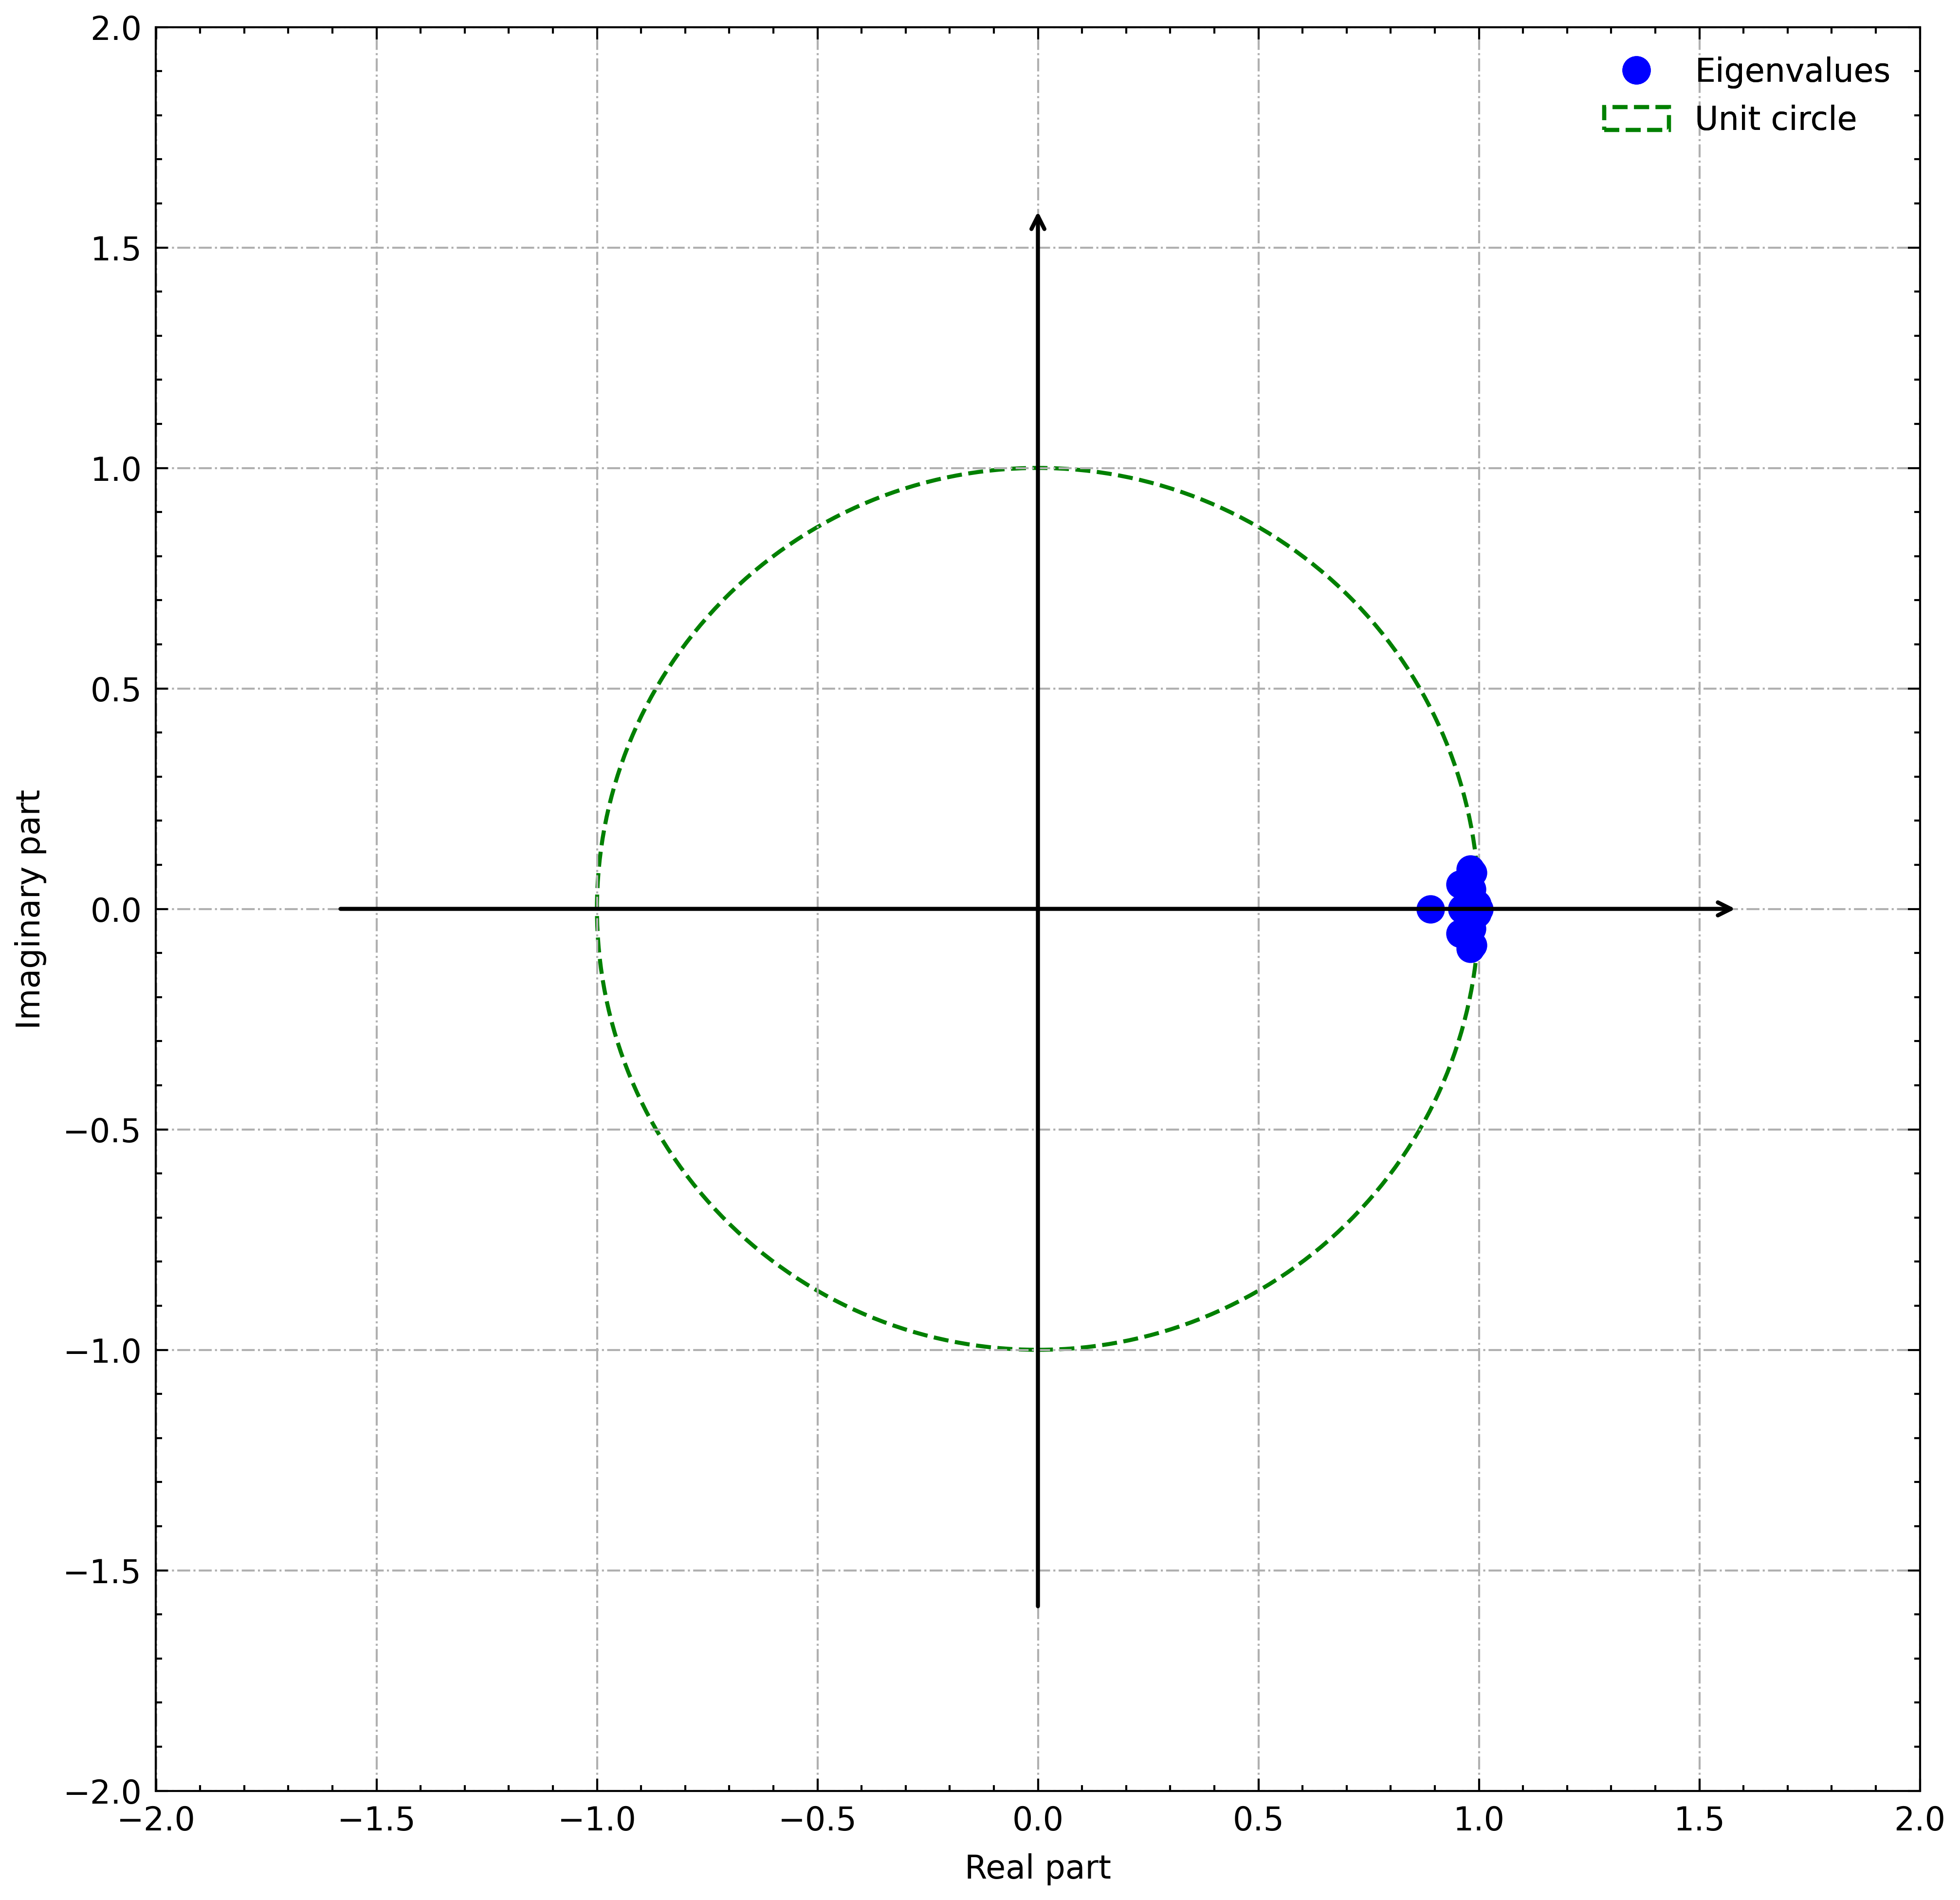

In [13]:
# for eig in dmd.eigs:
#     print(f'Eigenvalue {eig}: distance from unit circle {np.abs(eig.imag**2+eig.real**2 - 1)}')

dmds[0].plot_eigs(show_axes=True, show_unit_circle=True);

Done


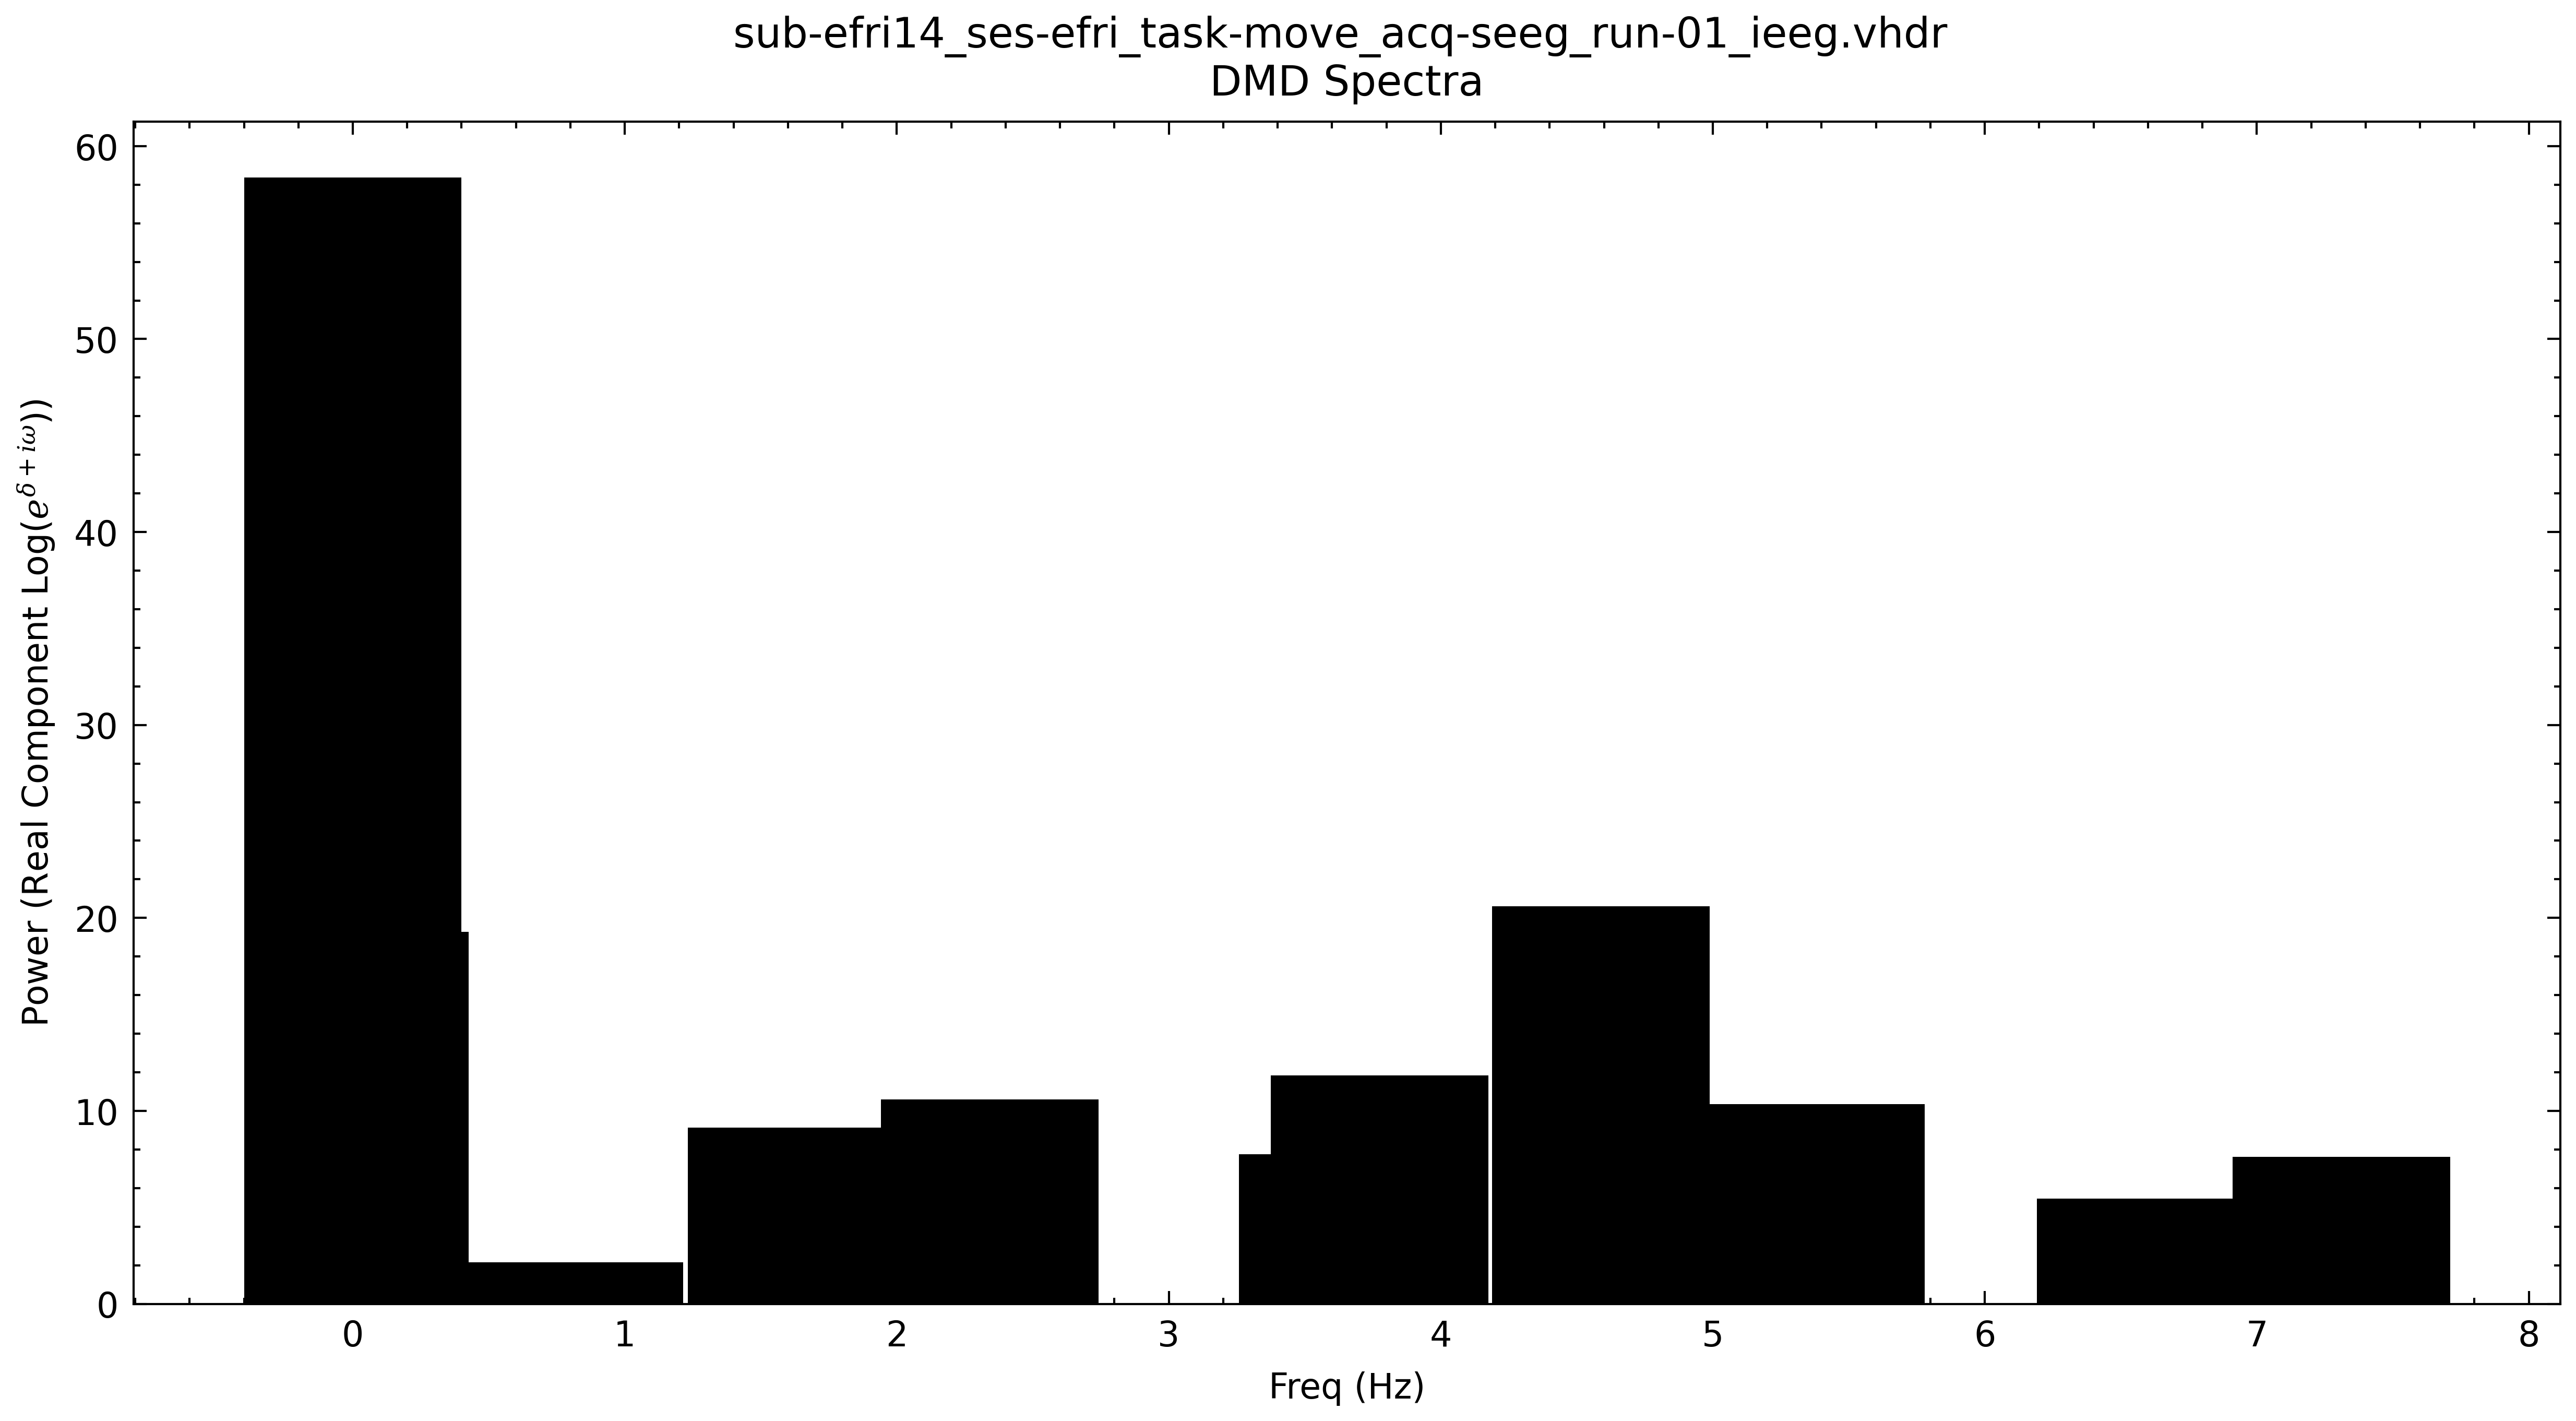

In [35]:
growth_rates, freqs = compute_frequencies(dmds[0].eigs, 1/epochs.info['sfreq'])
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(freqs, np.abs(growth_rates))
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (Real Component Log($e^{\delta + i \omega}$))',
    title=f'{bids_path.basename} \nDMD Spectra',
)
print('Done')

In [14]:
# for mode in dmd.modes.T:
#     plt.plot(np.arange(ntrials*nchs), mode.real)
#     plt.title('Modes')
# plt.show()

# for dynamic in dmd.dynamics:
#     plt.plot(epochs.times, dynamic.real)
#     plt.title('Dynamics')
# plt.show()

In [15]:
dmd_modes = np.array([np.absolute(dmd.modes) for dmd in dmds])
dmd_modes.shape

(128, 81, 26)

In [16]:
X_dmd = dmd_modes.reshape(ntrials, -1)

In [30]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=svd_rank,
)

stratified_kf_scores_dmd = cv_fit(mtsmorf, X_dmd, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_dmd.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

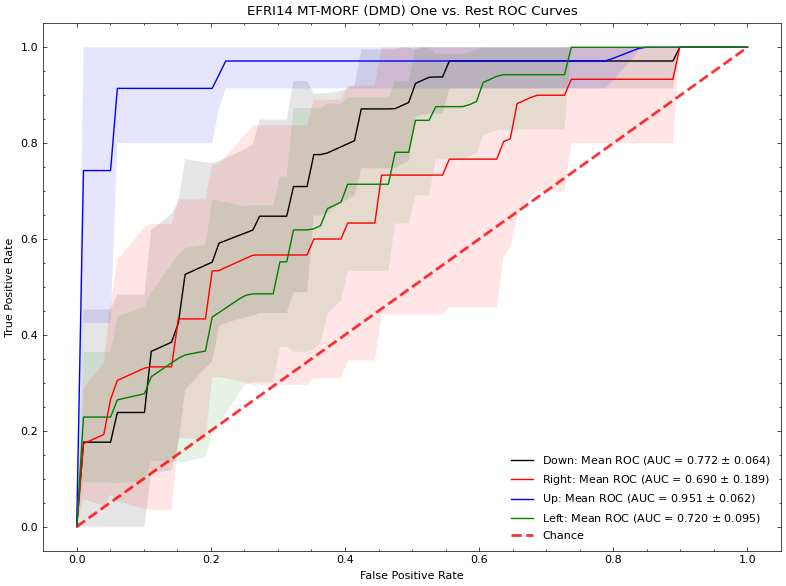

In [31]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_dmd["test_predict_proba"],
    X_dmd,
    y,
    stratified_kf_scores_dmd["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF (DMD) One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [36]:
hodmds = []

svd_rank = 234
h = int(np.ceil(2 * nsteps / nchs))
for i in tqdm(range(ntrials)):
    hodmd = HODMD(svd_rank=svd_rank, exact=True, opt=True, d=h)
    
    snapshots = epochs_data[i]
    hodmd.fit(snapshots)
    hodmds.append(hodmd)

100%|██████████| 128/128 [02:15<00:00,  1.06s/it]


In [37]:
hodmds[0].modes.shape

(81, 234)

In [38]:
# from scipy.linalg import svdvals

# fig, ax = plt.subplots(figsize=(4,3))
# ax.plot(svdvals(np.array([snapshot.flatten() for snapshot in epochs_data.transpose([2,0,1])]).T), 'o')
# fig.tight_layout();

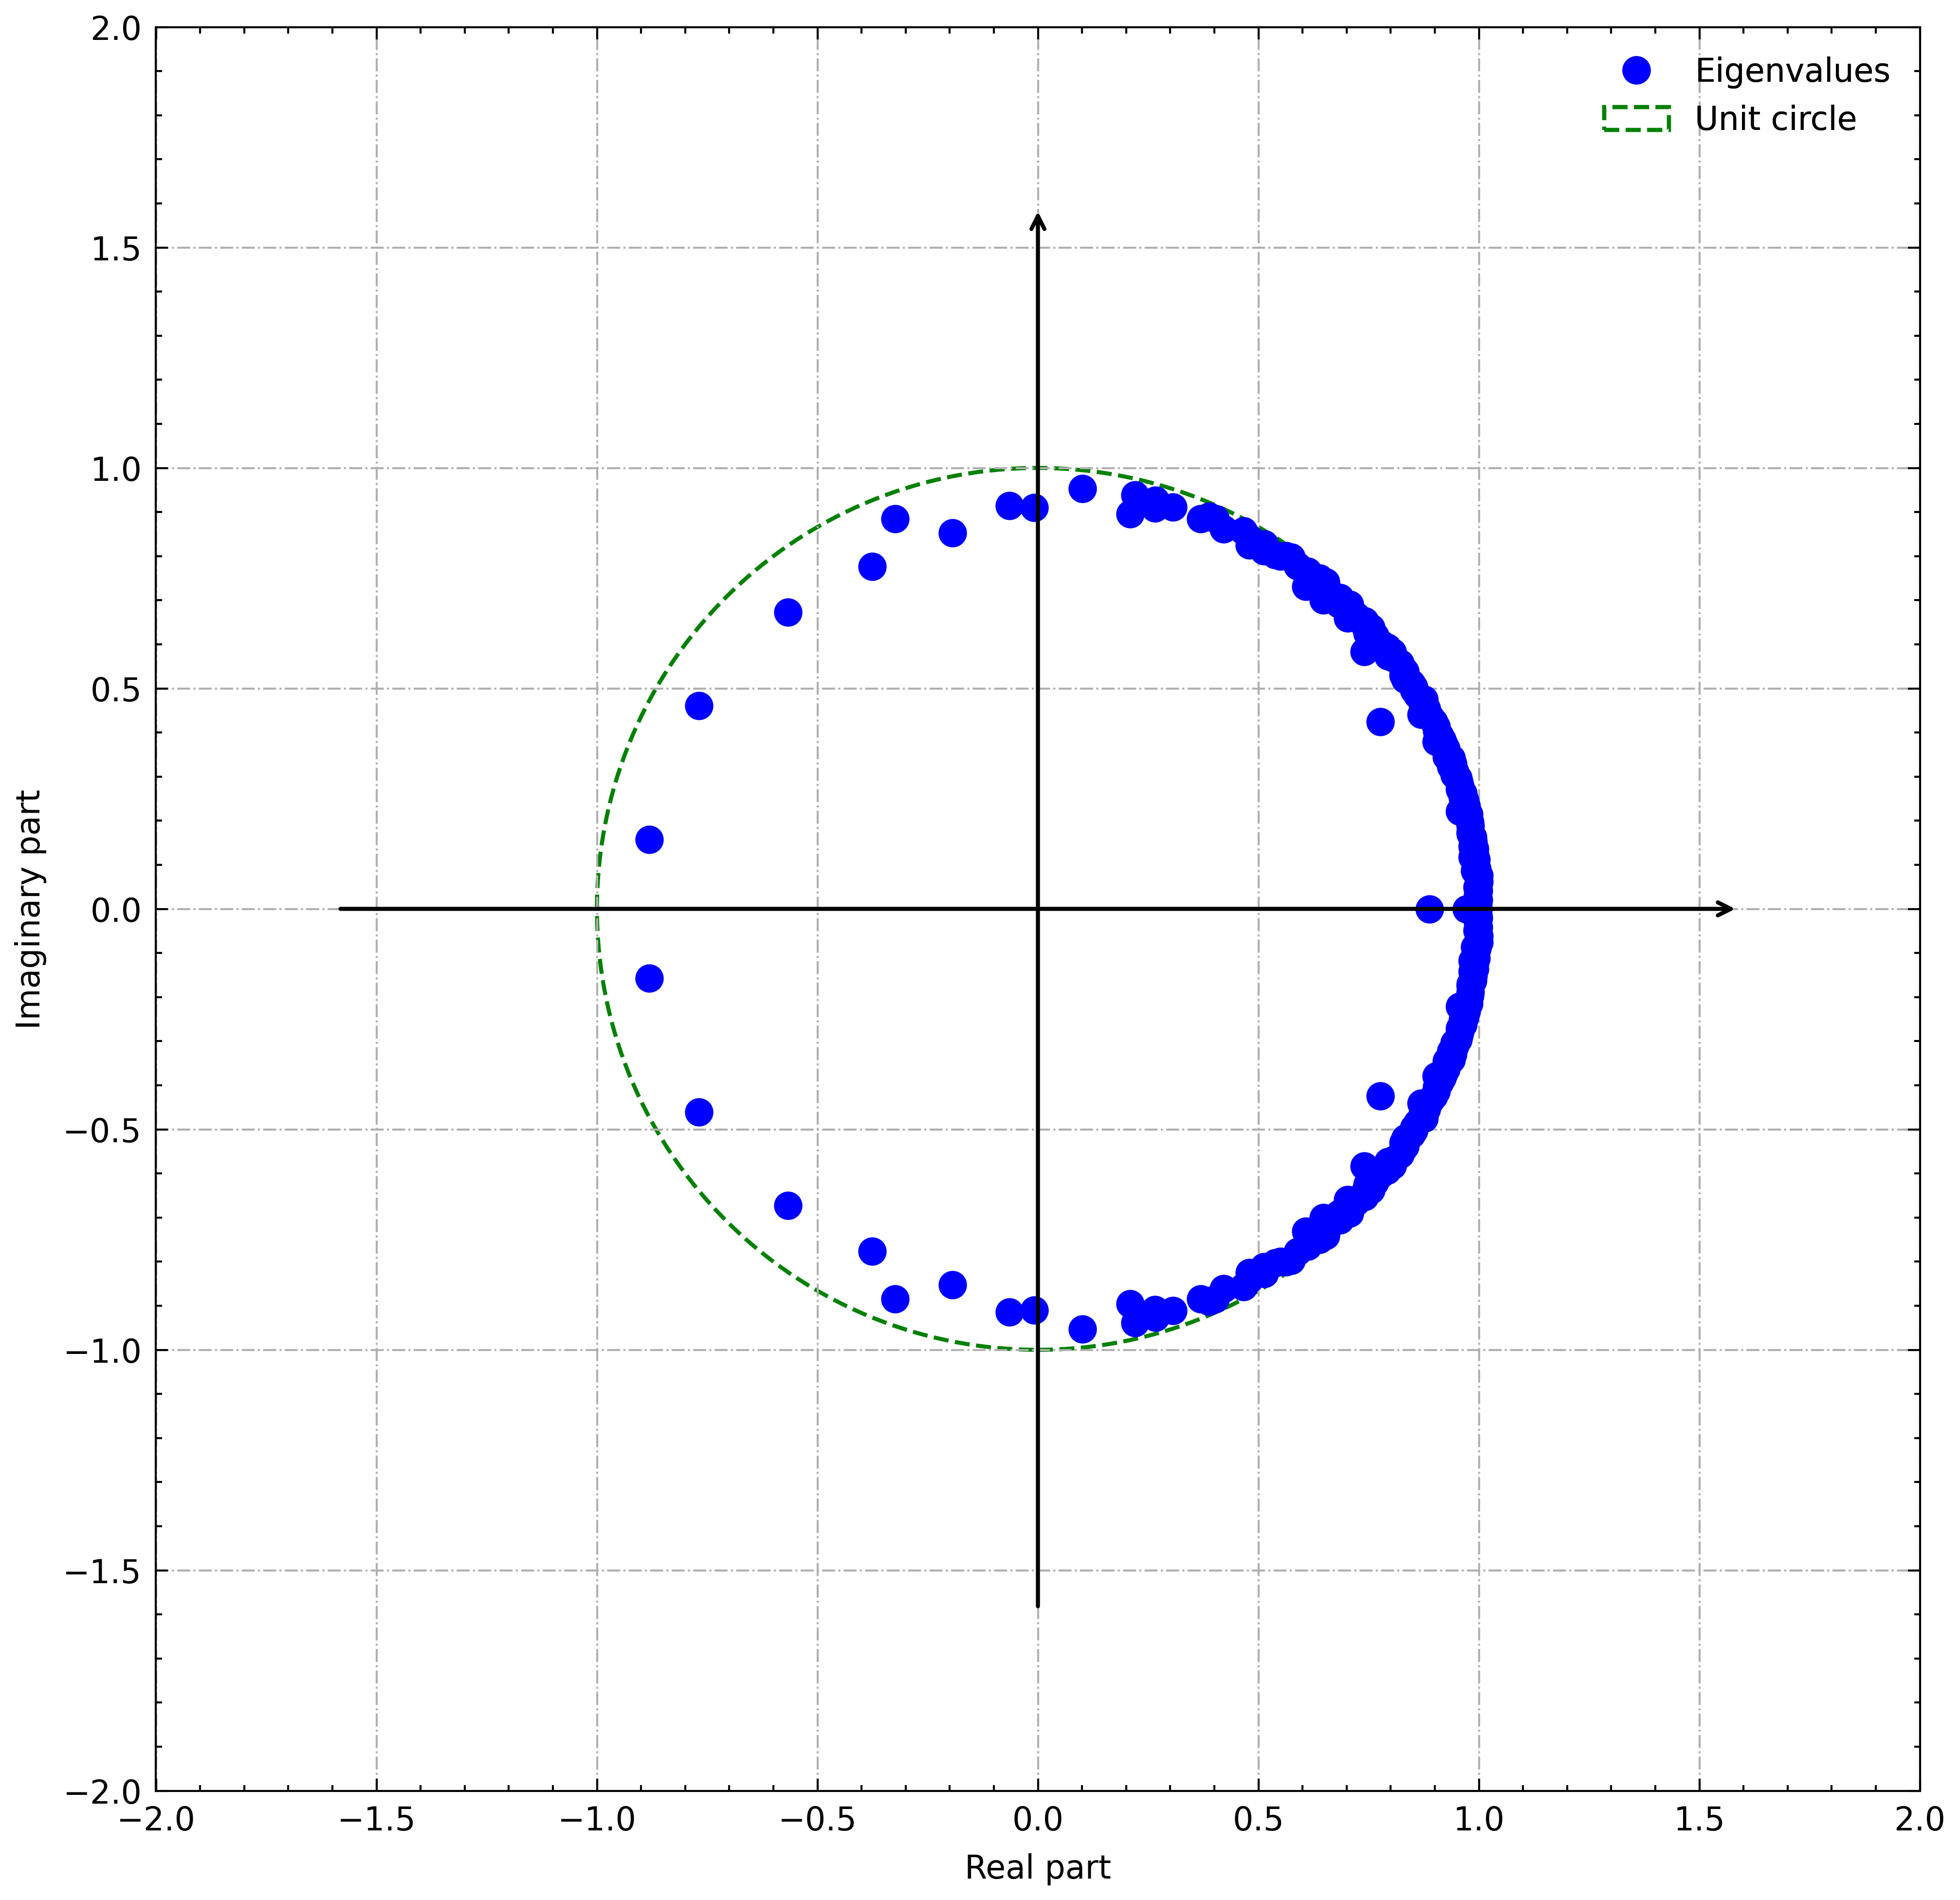

In [39]:
# for eig in dmd.eigs:
#     print(f'Eigenvalue {eig}: distance from unit circle {np.abs(eig.imag**2+eig.real**2 - 1)}')

hodmds[0].plot_eigs(show_axes=True, show_unit_circle=True);

Done


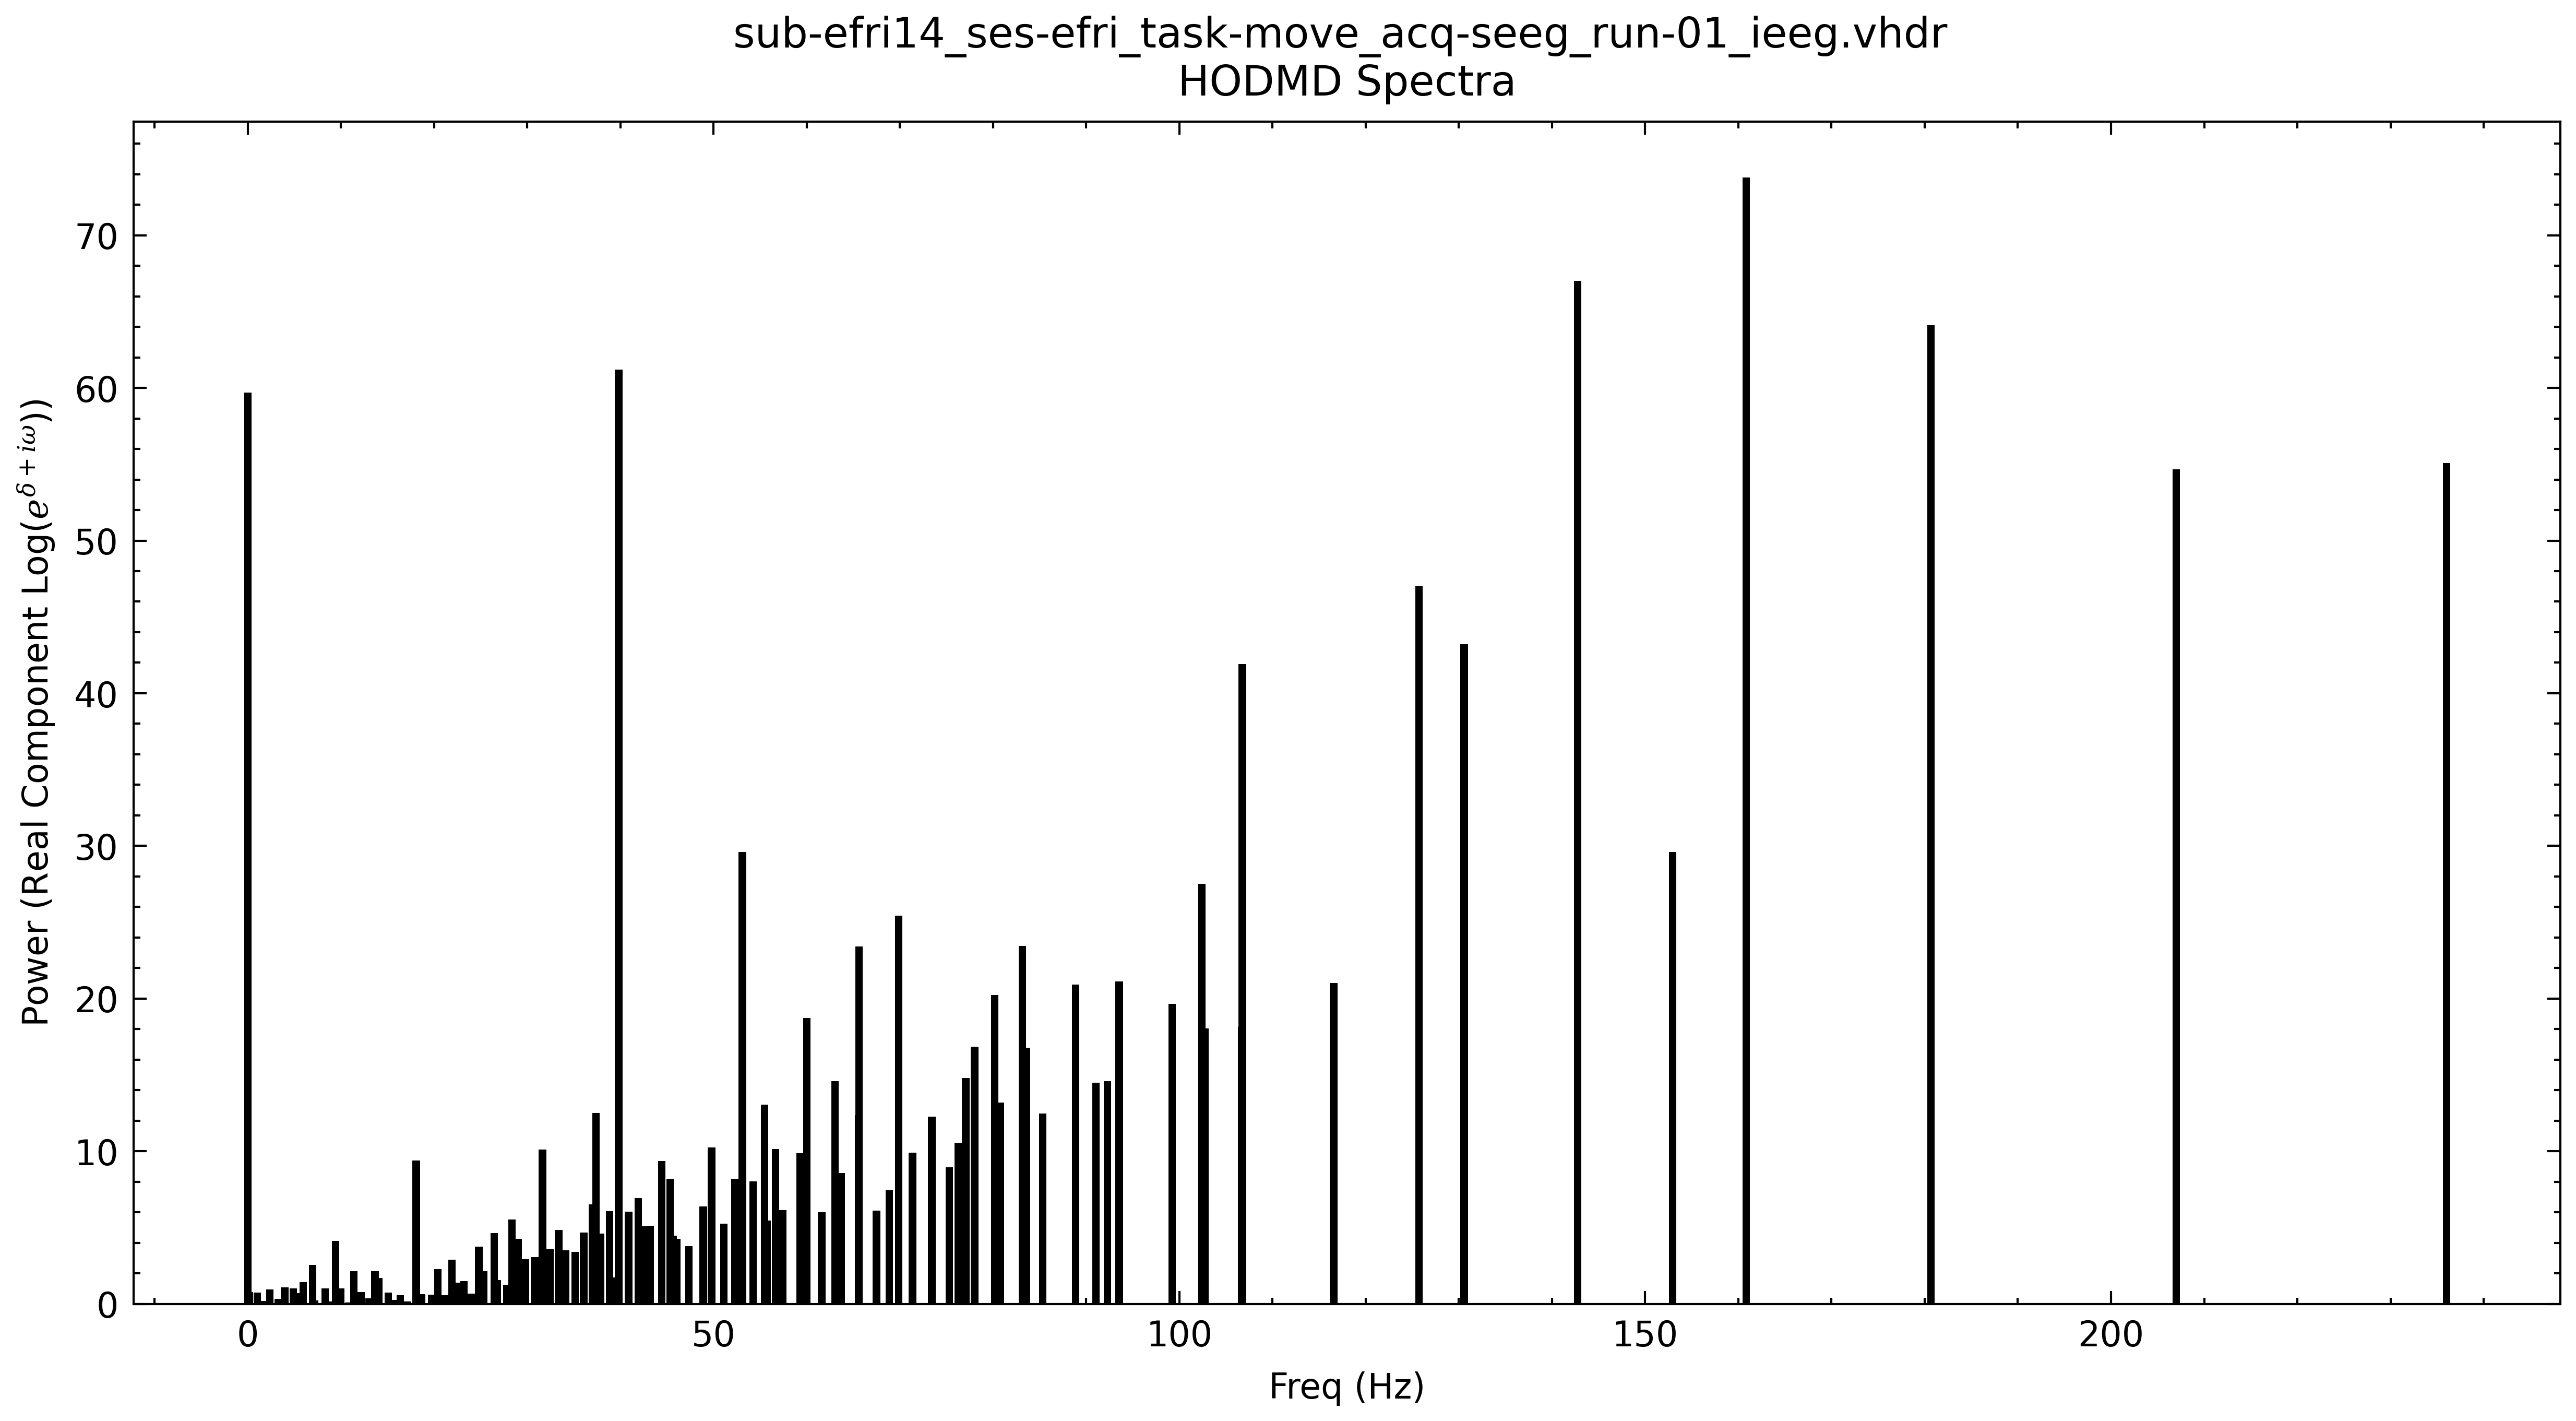

In [40]:
growth_rates, freqs = compute_frequencies(hodmds[0].eigs, 1/epochs.info['sfreq'])
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(freqs, np.abs(growth_rates))
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (Real Component Log($e^{\delta + i \omega}$))',
    title=f'{bids_path.basename} \nHODMD Spectra',
)
print('Done')

In [36]:
# for mode in dmd.modes.T:
#     plt.plot(np.arange(ntrials*nchs), mode.real)
#     plt.title('Modes')
# plt.show()

# for dynamic in dmd.dynamics:
#     plt.plot(epochs.times, dynamic.real)
#     plt.title('Dynamics')
# plt.show()

In [37]:
hodmd_modes = np.array([np.absolute(hodmd.modes) for hodmd in hodmds])
hodmd_modes.shape

(128, 81, 234)

In [38]:
X_hodmd = hodmd_modes.reshape(ntrials, -1)

In [39]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=svd_rank,
)

stratified_kf_scores_hodmd = cv_fit(mtsmorf, X_dmd, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_hodmd.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

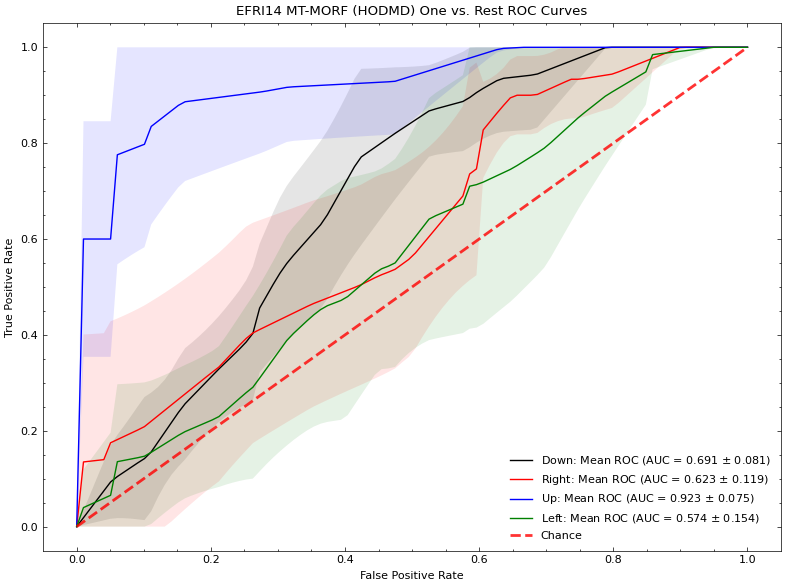

In [40]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_hodmd["test_predict_proba"],
    X_hodmd,
    y,
    stratified_kf_scores_hodmd["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF (HODMD) One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout();

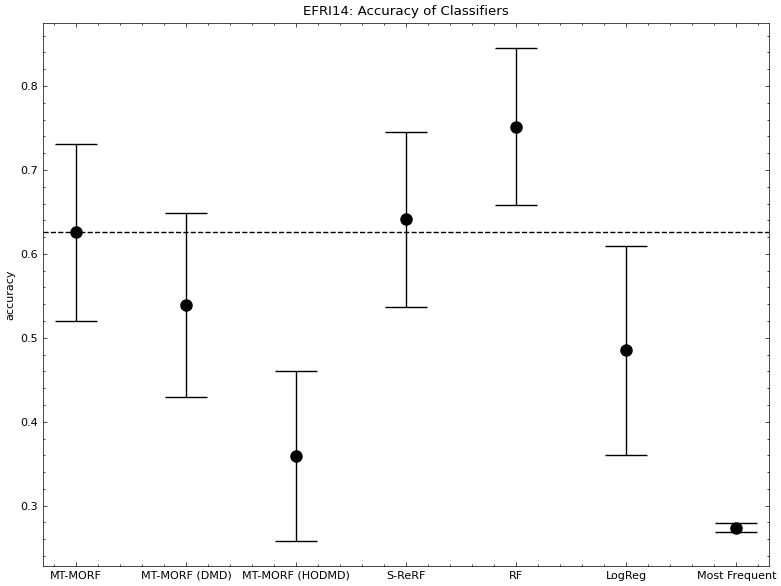

In [41]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

clf_names = [
    'MT-MORF', 
    'MT-MORF (DMD)',
    'MT-MORF (HODMD)',
    'S-ReRF', 
    'RF', 
    'LogReg', 
    'Most Frequent'
]
accs = np.array([
        np.mean(stratified_kf_scores["test_accuracy"]), 
        np.mean(stratified_kf_scores_dmd["test_accuracy"]),
        np.mean(stratified_kf_scores_hodmd["test_accuracy"]),
        np.mean(stratified_kf_scores_srerf["test_accuracy"]), 
        np.mean(stratified_kf_scores_rf["test_accuracy"]),
        np.mean(stratified_kf_scores_lr["test_accuracy"]),
        np.mean(stratified_kf_scores_dummy["test_accuracy"]),
    ])
acc_std = np.array([
        np.std(stratified_kf_scores["test_accuracy"]), 
        np.std(stratified_kf_scores_dmd["test_accuracy"]), 
        np.std(stratified_kf_scores_hodmd["test_accuracy"]), 
        np.std(stratified_kf_scores_srerf["test_accuracy"]),
        np.std(stratified_kf_scores_rf["test_accuracy"]),
        np.std(stratified_kf_scores_lr["test_accuracy"]),
        np.std(stratified_kf_scores_dummy["test_accuracy"]),
    ])

ax.errorbar(clf_names, accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(stratified_kf_scores["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers")
fig.tight_layout();

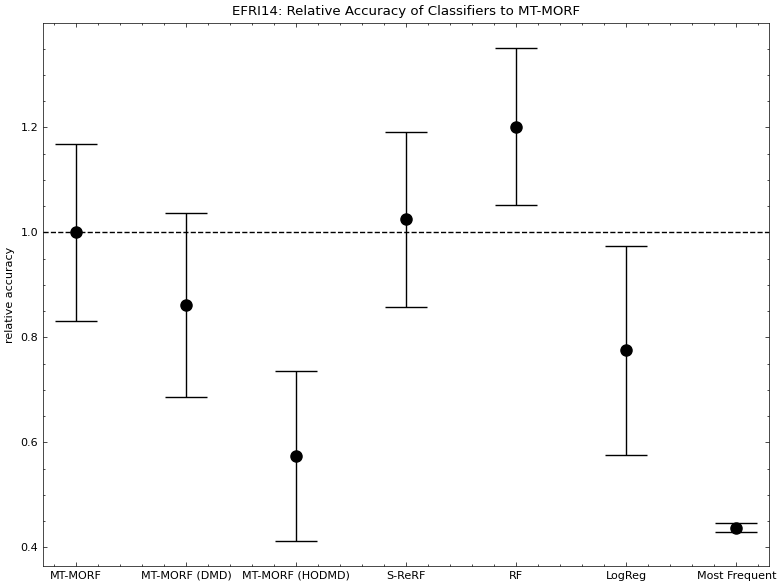

In [42]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

clf_names = [
    'MT-MORF', 
    'MT-MORF (DMD)',
    'MT-MORF (HODMD)',
    'S-ReRF', 
    'RF', 
    'LogReg', 
    'Most Frequent'
]
accs = np.array([
        np.mean(stratified_kf_scores["test_accuracy"]), 
        np.mean(stratified_kf_scores_dmd["test_accuracy"]),
        np.mean(stratified_kf_scores_hodmd["test_accuracy"]),
        np.mean(stratified_kf_scores_srerf["test_accuracy"]), 
        np.mean(stratified_kf_scores_rf["test_accuracy"]),
        np.mean(stratified_kf_scores_lr["test_accuracy"]),
        np.mean(stratified_kf_scores_dummy["test_accuracy"]),
    ])
acc_std = np.array([
        np.std(stratified_kf_scores["test_accuracy"]), 
        np.std(stratified_kf_scores_dmd["test_accuracy"]), 
        np.std(stratified_kf_scores_hodmd["test_accuracy"]), 
        np.std(stratified_kf_scores_srerf["test_accuracy"]),
        np.std(stratified_kf_scores_rf["test_accuracy"]),
        np.std(stratified_kf_scores_lr["test_accuracy"]),
        np.std(stratified_kf_scores_dummy["test_accuracy"]),
    ])

rel_accs = accs / np.mean(stratified_kf_scores["test_accuracy"])
rel_acc_std = acc_std / np.mean(stratified_kf_scores["test_accuracy"])

ax.errorbar(clf_names, rel_accs, yerr=rel_acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(1, lw=1, color='k', ls='--')
ax.set(ylabel="relative accuracy", title=f"{subject.upper()}: Relative Accuracy of Classifiers to MT-MORF")
fig.tight_layout();

In [20]:
X_dmd_recon = np.array([dmd.reconstructed_data.real for dmd in dmds]).reshape(ntrials, -1)

In [44]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores_dmd_recon = cv_fit(mtsmorf, X_dmd_recon, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_dmd_recon.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

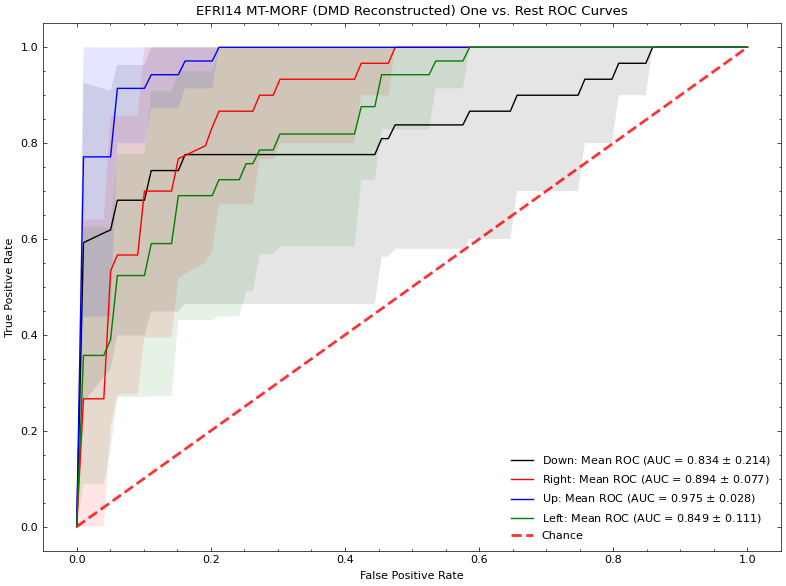

In [45]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_dmd_recon["test_predict_proba"],
    X_dmd_recon,
    y,
    stratified_kf_scores_dmd_recon["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF (DMD Reconstructed) One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [46]:
X_hodmd_recon = np.array([hodmd.reconstructed_data.real for hodmd in hodmds]).reshape(ntrials, -1)

In [47]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores_hodmd_recon = cv_fit(mtsmorf, X_hodmd_recon, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_hodmd_recon.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

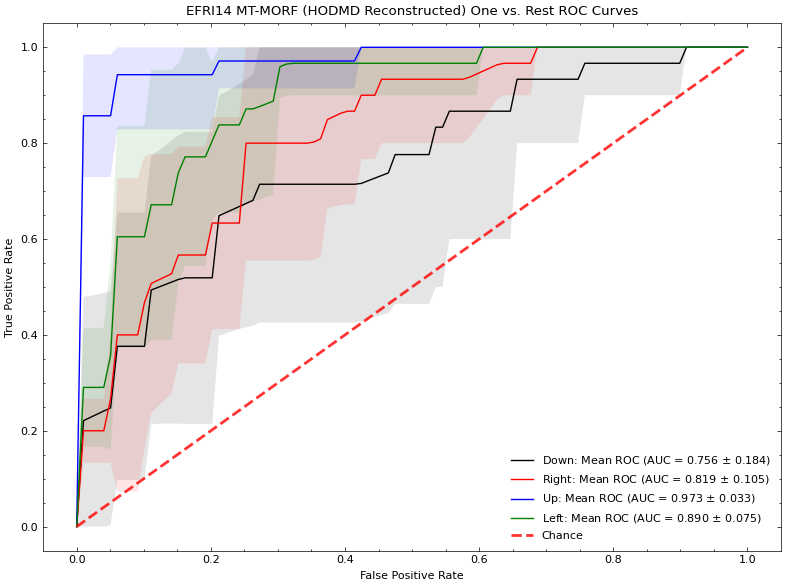

In [48]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_hodmd_recon["test_predict_proba"],
    X_hodmd_recon,
    y,
    stratified_kf_scores_hodmd_recon["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF (HODMD Reconstructed) One vs. Rest ROC Curves",
)
ax.legend(loc="lower right")
fig.tight_layout();

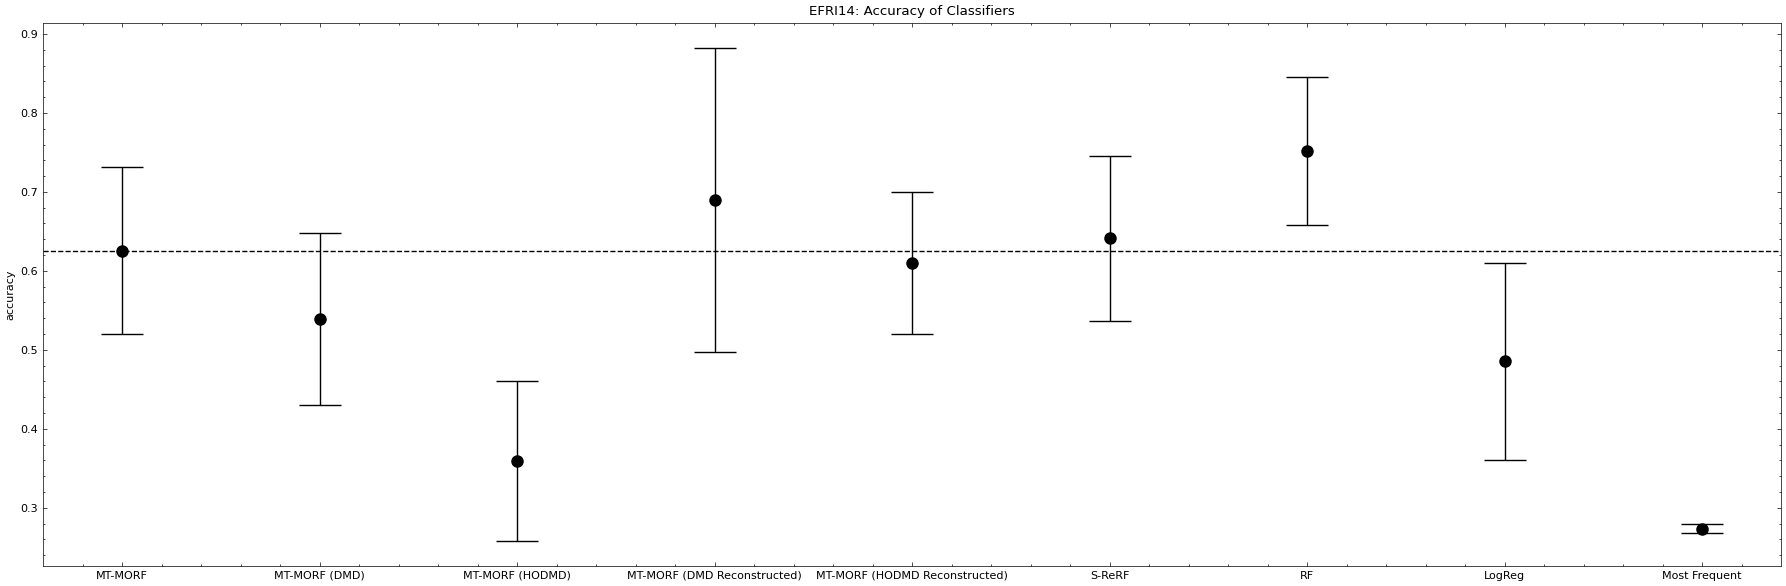

In [57]:
fig, ax = plt.subplots(dpi=100, figsize=(18,6))

clf_names = [
    'MT-MORF', 
    'MT-MORF (DMD)',
    'MT-MORF (HODMD)', 
    'MT-MORF (DMD Reconstructed)', 
    'MT-MORF (HODMD Reconstructed)', 
    'S-ReRF', 
    'RF', 
    'LogReg', 
    'Most Frequent'
]
accs = np.array([
        np.mean(stratified_kf_scores["test_accuracy"]), 
        np.mean(stratified_kf_scores_dmd["test_accuracy"]),
        np.mean(stratified_kf_scores_hodmd["test_accuracy"]),
        np.mean(stratified_kf_scores_dmd_recon["test_accuracy"]),
        np.mean(stratified_kf_scores_hodmd_recon["test_accuracy"]),
        np.mean(stratified_kf_scores_srerf["test_accuracy"]), 
        np.mean(stratified_kf_scores_rf["test_accuracy"]),
        np.mean(stratified_kf_scores_lr["test_accuracy"]),
        np.mean(stratified_kf_scores_dummy["test_accuracy"]),
    ])
acc_std = np.array([
        np.std(stratified_kf_scores["test_accuracy"]), 
        np.std(stratified_kf_scores_dmd["test_accuracy"]),
        np.std(stratified_kf_scores_hodmd["test_accuracy"]),
        np.std(stratified_kf_scores_dmd_recon["test_accuracy"]),
        np.std(stratified_kf_scores_hodmd_recon["test_accuracy"]),
        np.std(stratified_kf_scores_srerf["test_accuracy"]),
        np.std(stratified_kf_scores_rf["test_accuracy"]),
        np.std(stratified_kf_scores_lr["test_accuracy"]),
        np.std(stratified_kf_scores_dummy["test_accuracy"]),
    ])

ax.errorbar(clf_names, accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(stratified_kf_scores["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers")
fig.tight_layout();

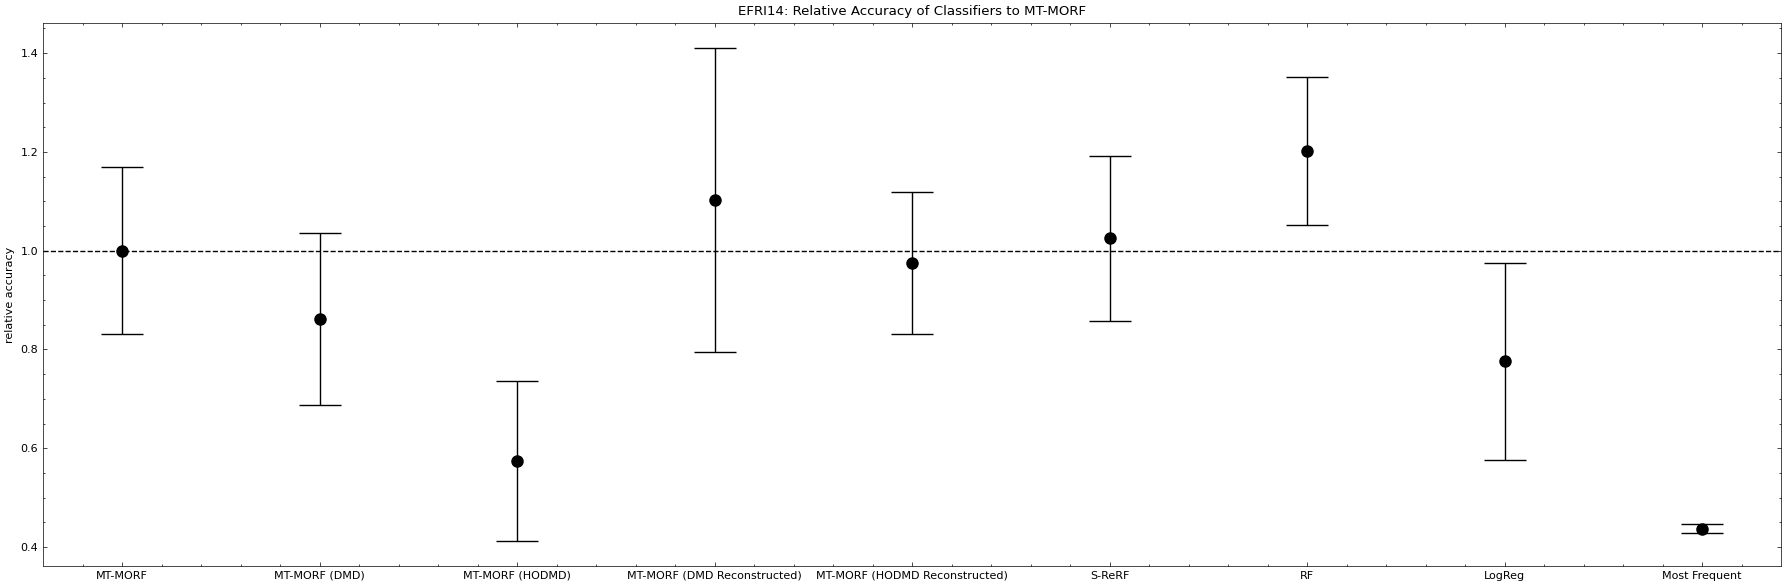

In [56]:
fig, ax = plt.subplots(dpi=100, figsize=(18,6))

clf_names = [
    'MT-MORF', 
    'MT-MORF (DMD)',
    'MT-MORF (HODMD)', 
    'MT-MORF (DMD Reconstructed)', 
    'MT-MORF (HODMD Reconstructed)', 
    'S-ReRF', 
    'RF', 
    'LogReg', 
    'Most Frequent'
]
accs = np.array([
        np.mean(stratified_kf_scores["test_accuracy"]), 
        np.mean(stratified_kf_scores_dmd["test_accuracy"]),
        np.mean(stratified_kf_scores_hodmd["test_accuracy"]),
        np.mean(stratified_kf_scores_dmd_recon["test_accuracy"]),
        np.mean(stratified_kf_scores_hodmd_recon["test_accuracy"]),
        np.mean(stratified_kf_scores_srerf["test_accuracy"]), 
        np.mean(stratified_kf_scores_rf["test_accuracy"]),
        np.mean(stratified_kf_scores_lr["test_accuracy"]),
        np.mean(stratified_kf_scores_dummy["test_accuracy"]),
    ])
acc_std = np.array([
        np.std(stratified_kf_scores["test_accuracy"]), 
        np.std(stratified_kf_scores_dmd["test_accuracy"]),
        np.std(stratified_kf_scores_hodmd["test_accuracy"]),
        np.std(stratified_kf_scores_dmd_recon["test_accuracy"]),
        np.std(stratified_kf_scores_hodmd_recon["test_accuracy"]),
        np.std(stratified_kf_scores_srerf["test_accuracy"]),
        np.std(stratified_kf_scores_rf["test_accuracy"]),
        np.std(stratified_kf_scores_lr["test_accuracy"]),
        np.std(stratified_kf_scores_dummy["test_accuracy"]),
    ])

rel_accs = accs / np.mean(stratified_kf_scores["test_accuracy"])
rel_acc_std = acc_std / np.mean(stratified_kf_scores["test_accuracy"])

ax.errorbar(clf_names, rel_accs, yerr=rel_acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(1, lw=1, color='k', ls='--')
ax.set(ylabel="relative accuracy", title=f"{subject.upper()}: Relative Accuracy of Classifiers to MT-MORF")
fig.tight_layout();

In [26]:
# Initialize classifiers
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)
srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)
rf = RandomForestClassifier(random_state=rng)
lr = LogisticRegression(random_state=rng)
dummy = DummyClassifier(strategy="most_frequent", random_state=rng)

clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

In [27]:
metrics = [
    "accuracy",
    "roc_auc_ovr",
]

clf_scores = dict()

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__
    
    clf_scores[clf_name] = cv_fit(
        clf,
        X_dmd_recon,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

100%|██████████| 5/5 [06:50<00:00, 82.17s/it]


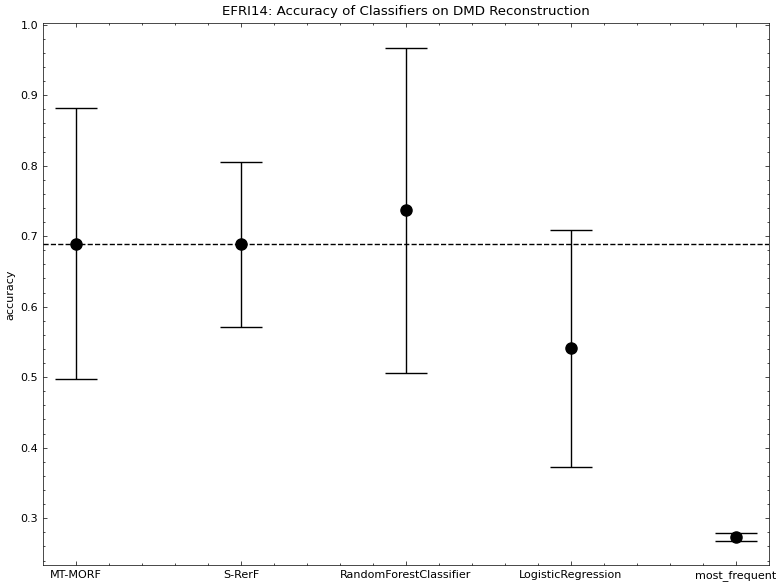

In [29]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

accs = []
acc_std = []
for clf_name, scores in clf_scores.items():
    accs.append(np.mean(scores["test_accuracy"]))
    acc_std.append(np.std(scores["test_accuracy"]))

accs = np.array(accs)
acc_std = np.array(acc_std)

ax.errorbar(list(clf_scores.keys()), accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(clf_scores["MT-MORF"]["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers on DMD Reconstruction")
fig.tight_layout();

## Feature Importance
- Remove B7
- Permutation importance (RAM issue -- need to run locally)

In [ ]:
import json
results_path = Path("/workspaces/research/seeg localization/SPORF/mtsmorf/results")

with open(results_path / f"{subject}/MT-MORF_results.json") as fout:
    scores = json.load(fout)

In [ ]:
scoring_method = "roc_auc_ovr"
result = dict(
    importances_mean=scores[f"validate_{scoring_method}_imp_mean"],
    importances_std=scores[f"validate_{scoring_method}_imp_mean"],
)


In [ ]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 10))
plot_feature_importances(result, epochs.ch_names, epochs.times, ax=ax)
ax.set(title=f"{subject.upper()}: Feature Importances {scoring_method}")
fig.tight_layout()

In [ ]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

In [ ]:
# read dataset as an epoch
tmin, tmax = (-0.5, 1.0)

# get EEG data
epochs = read_dataset(bids_path, tmin=tmin, tmax=tmax, picks=picks, event_key="Left Target")
epochs = epochs.drop(unsuccessful_trial_inds)
epochs.load_data()
epochs_data = epochs.get_data()

# get shape of data
ntrials, nchs, nsteps = epochs_data.shape

# check there are equal number of trials and labels
assert(ntrials == labels.shape[0]), "Unequal number of trials and labels"

In [ ]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Band-pass filter 1 Hz to sfreq/2
data = mne.filter.filter_data(epochs_data, sfreq=2000, l_freq=1, h_freq=999)
X = data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

In [ ]:
test_size = 0.2
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=test_size, random_state=rng, stratify=y)

In [ ]:
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

mtsmorf.fit(Xtrain, ytrain)

preds = np.array(mtsmorf.predict(Xtest))

print(Counter(preds))
print(f"Accuracy: {accuracy_score(ytest, preds)}")

In [ ]:
fig, ax = plt.subplots(dpi=100)
plot_confusion_matrix(mtsmorf, Xtest, ytest, cmap='Blues', ax=ax)

ax.set(xticklabels=['down', 'right', 'up', 'left'], yticklabels=['down', 'right', 'up', 'left']);

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
lw = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(ytest, classes=[0,1,2,3])[:, i], label_binarize(preds, classes=[0,1,2,3])[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['#D5484B', '#297B9D', '#487163', '#E4CE67', '#87425D'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One vs. Rest ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Score with roc_auc_ovr
n_repeats = 5
result = permutation_importance(mtsmorf, Xtest, ytest, scoring='roc_auc_ovr', n_repeats=n_repeats, n_jobs=1, random_state=1)

# for i in result.importances_mean.argsort()[::-1]:
#     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
#         # print(f"{diabetes.feature_names[i]:<8}"
#         print(f"{result.importances_mean[i]:.3f}"
#               f" +/- {result.importances_std[i]:.3f}")

feat_importance_means = result['importances_mean'].reshape(nchs, nsteps)
feat_importance_stds = result['importances_std'].reshape(nchs, nsteps)
feat_importances = result['importances'].reshape(nchs, nsteps, n_repeats)

In [ ]:
df_feat_importance = pd.DataFrame(feat_importance_means)

sns.heatmap(df_feat_importance, annot=True, cmap='Blues', ax=ax)